In [2]:
import pandas as pd
%load_ext autoreload
%autoreload 2
from ff_energy.ffe.slurm import SlurmJobHandler
from pathlib import Path
import pandas as pd
import jax.numpy as jnp
import itertools as it
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ff_energy.ffe.potential import (
    LJ,
    DE,
)
from ff_energy.ffe.ff import FF
from ff_energy.ffe.constants import FFEPATH, PDB_PATH
from ff_energy.plotting.ffe_plots import plot_energy_MSE, plot_ff_fit
from ff_energy.plotting.plotting import set_style
from ff_energy.plotting.fit_results import residuals_plot, residuals_from_keys
from ff_energy.logs.logging import hide_logs
from ff_energy.ffe.potential import LJ, LJ_bound, DE

hide_logs()
import scienceplots
set_style(no_latex=True)

from ff_energy.ffe.ff_fit import (
    load_ff,
    fit_func,
    fit_repeat,
)

from ff_energy.utils.ffe_utils import pickle_output, read_from_pickle, str2int, PKL_PATH
from ff_energy.utils.json_utils import load_json
from ff_energy.ffe.structure import atom_key_pairs

from ff_energy.utils.ffe_utils import pickle_output, read_from_pickle, str2int, \
    PKL_PATH, get_structures

from sklearn.metrics import mean_squared_error as calc_rmse


0 ('C', 'C')
1 ('C', 'CG331')
2 ('C', 'CL')
3 ('C', 'CLA')
4 ('C', 'H')
5 ('C', 'HGA3')
6 ('C', 'HGP1')
7 ('C', 'HT')
8 ('C', 'OG311')
9 ('C', 'OT')
10 ('C', 'POT')
11 ('CG331', 'CG331')
12 ('CG331', 'CL')
13 ('CG331', 'CLA')
14 ('CG331', 'H')
15 ('CG331', 'HGA3')
16 ('CG331', 'HGP1')
17 ('CG331', 'HT')
18 ('CG331', 'OG311')
19 ('CG331', 'OT')
20 ('CG331', 'POT')
21 ('CL', 'CL')
22 ('CL', 'CLA')
23 ('CL', 'H')
24 ('CL', 'HGA3')
25 ('CL', 'HGP1')
26 ('CL', 'HT')
27 ('CL', 'OG311')
28 ('CL', 'OT')
29 ('CL', 'POT')
30 ('CLA', 'CLA')
31 ('CLA', 'H')
32 ('CLA', 'HGA3')
33 ('CLA', 'HGP1')
34 ('CLA', 'HT')
35 ('CLA', 'OG311')
36 ('CLA', 'OT')
37 ('CLA', 'POT')
38 ('H', 'H')
39 ('H', 'HGA3')
40 ('H', 'HGP1')
41 ('H', 'HT')
42 ('H', 'OG311')
43 ('H', 'OT')
44 ('H', 'POT')
45 ('HGA3', 'HGA3')
46 ('HGA3', 'HGP1')
47 ('HGA3', 'HT')
48 ('HGA3', 'OG311')
49 ('HGA3', 'OT')
50 ('HGA3', 'POT')
51 ('HGP1', 'HGP1')
52 ('HGP1', 'HT')
53 ('HGP1', 'OG311')
54 ('HGP1', 'OT')
55 ('HGP1', 'POT')
56 ('HT', 'HT'

<Figure size 100x100 with 0 Axes>

#  Old FF objects

In [3]:
FFOBJ = pd.read_pickle("/home/boittier/Documents/phd/ff_energy/pickles/ELECpol_dcm_lj_fitted.pkl")

In [4]:
FFOBJ.bounds

[(0.1, 5.5), (0.1, 5.5), (0.1, 5.5), (0.001, 0.1), (0.001, 0.1), (0.001, 0.1)]

In [5]:
FFOBJ.get_best_parm()

array([2.91835043e+00, 2.36176106e+00, 1.08528739e+00, 1.00012042e-03,
       4.37284593e-02, 4.55274630e-02])

In [6]:
s = "& "
for _ in FFOBJ.get_best_parm():
    s += f"{_:.4f} & "
print(s)

& 2.9184 & 2.3618 & 1.0853 & 0.0010 & 0.0437 & 0.0455 & 


In [7]:
pd.DataFrame(FFOBJ.opt_results).sort_values("fun")

,fun,nit,nfev,status,success,message,x,final_simplex
39,3.333783,1017,1637,0,True,Optimization terminated successfully.,"[2.9183504289252395, 2.361761064608869, 1.0852...","([[2.9183504289252395, 2.361761064608869, 1.08..."
43,3.340779,614,1011,0,True,Optimization terminated successfully.,"[2.866350690522338, 2.382496317763045, 1.04398...","([[2.866350690522338, 2.382496317763045, 1.043..."
56,3.341117,367,623,0,True,Optimization terminated successfully.,"[2.930282347121233, 2.388650180231048, 0.99875...","([[2.930282347121233, 2.388650180231048, 0.998..."
85,3.342337,849,1392,0,True,Optimization terminated successfully.,"[2.934864651835948, 2.3864479512842074, 0.9955...","([[2.934864651835948, 2.3864479512842074, 0.99..."
21,3.345323,1054,1679,0,True,Optimization terminated successfully.,"[2.9369894831168413, 2.395809129633962, 0.9729...","([[2.9369894831168413, 2.395809129633962, 0.97..."
...,...,...,...,...,...,...,...,...
46,396.796906,146,318,0,True,Optimization terminated successfully.,"[0.13088441956099872, 0.10133327266898273, 0.1...","([[0.13088441956099872, 0.10133327266898273, 0..."
76,396.796936,70,206,0,True,Optimization terminated successfully.,"[0.14256841816467086, 0.1, 0.11224886033813891...","([[0.14256841816467086, 0.1, 0.112248860338138..."
59,396.796936,81,230,0,True,Optimization terminated successfully.,"[0.17008248193940725, 0.10090734575885196, 0.1...","([[0.17008248193940725, 0.10090734575885196, 0..."
2,396.796997,82,229,0,True,Optimization terminated successfully.,"[0.12633238655017687, 0.13817265821374175, 0.1...","([[0.12633238655017687, 0.13817265821374175, 0..."


In [8]:
# ljpcff_fit = fit_repeat(FFOBJ,
#              2,
#              "test",
#              loss="jax",
#             quiet=False)

In [9]:
# plt.hist(ljpcff_fit.targets)

# Mike's Data

In [10]:
polE = [-0.930136854552888,
-1.31507799417835,
-1.45628955947725,
-1.67346295904183,
-1.42199432366542,
-1.15167880674309,
-1.35902810968711,
-0.859601100134316,
-1.84913675188034,
-0.856483829393135,
-1.2718227088059,
-1.56084163915229,
-1.39261881550939,
-1.43835214588841,
-1.30075772677199,
-1.48228282635899,
-0.680920009519745,
-2.20981511501319,
-1.17975446549458,
-1.08546659941582,]

In [11]:
ciE = [-22.4086494347023,
-26.4374340709503,
-19.1780477254699,
-34.7284358276397,
-24.4589460449043,
-34.0066776503134,
-28.2402888688846,
-16.6001352641328,
-26.4178367918179,
-18.1167660766821,
-27.1959819486011,
-29.4556212632235,
-28.9918807192649,
-25.4210448380067,
-29.4795196243424,
-23.4421040897108,
-17.8969222278839,
-35.5716323589184,
-34.6954475859257,
-16.3395107453596,]

In [12]:
names = ["100_0_DCM_0_0",
"100_1_DCM_1_1",
"100_2_DCM_2_2",
"100_3_DCM_3_3",
"100_4_DCM_4_4",
"100_5_DCM_5_5",
"100_6_DCM_6_6",
"100_7_DCM_7_7",
"100_8_DCM_8_8",
"100_9_DCM_9_9",
"100_10_DCM_10_10",
"100_11_DCM_11_11",
"100_12_DCM_12_12",
"100_13_DCM_13_13",
"100_14_DCM_14_14",
"100_15_DCM_15_15",
"100_16_DCM_16_16",
"100_17_DCM_17_17",
"100_18_DCM_18_18",
"100_19_DCM_19_19",]

#  New structures

In [13]:
data = pd.read_pickle(
    "/home/boittier/Documents/phd/ff_energy/pickles/dcm_test_pbe0dz_pc.pkl")

In [14]:
data_ = data.data
data_.index = [str(_).upper() for _ in data_.KEY]
# data_["KEY"] = [str(_).upper() for _ in data_.KEY]

In [15]:
structure = "dcm_test"
structs, _ = get_structures(structure,
                            pdbpath=PDB_PATH / structure)

Structure/PDB already already exists, loading from pickle
Structures/PDBs loaded 20 20


In [16]:
# data_ = data_.dropna()
# data_ = data_.sort_index().drop_duplicates()
data_.loc[names]


,TOTAL,ELEC,VDW,KEY,M_ENERGY,n_monomers,C_ENERGY,intE,C_ENERGY_kcalmol
100_0_DCM_0_0,10.46182,-2.32637,-38.95443,100_0_DCM_0_0,-19187.350847,20,-19187.382260,-19.712028,-1.204014e+07
100_1_DCM_1_1,9.26687,-2.87067,-33.14880,100_1_DCM_1_1,-19187.348046,20,-19187.365141,-10.727158,-1.204013e+07
100_2_DCM_2_2,9.31088,-1.80053,-31.03154,100_2_DCM_2_2,-19187.340161,20,-19187.367136,-16.926831,-1.204013e+07
100_3_DCM_3_3,9.46549,-3.85909,-32.20855,100_3_DCM_3_3,-19187.331357,20,-19187.352384,-13.194738,-1.204012e+07
100_4_DCM_4_4,9.65906,-3.41737,-28.32044,100_4_DCM_4_4,-19187.350655,20,-19187.379647,-18.192711,-1.204014e+07
100_5_DCM_5_5,10.67199,-3.90189,-34.14801,100_5_DCM_5_5,-19187.358329,20,-19187.379848,-13.503250,-1.204014e+07
100_6_DCM_6_6,8.80933,-3.14770,-29.96899,100_6_DCM_6_6,-19187.349948,20,-19187.372958,-14.439258,-1.204013e+07
100_7_DCM_7_7,8.19969,-2.31133,-27.92680,100_7_DCM_7_7,-19187.360520,20,-19187.372740,-7.667666,-1.204013e+07
100_8_DCM_8_8,9.82647,-1.28969,-38.13678,100_8_DCM_8_8,-19187.354245,20,-19187.376712,-14.098330,-1.204014e+07
100_9_DCM_9_9,8.83827,-2.95552,-28.72102,100_9_DCM_9_9,-19187.351445,20,-19187.373646,-13.931514,-1.204013e+07


In [17]:
dists = {str(s.name)[:-4].lower(): s.distances for s in structs}

struct_data = structs[0]
sig_bound = (0.0025, 5.5)
ep_bound = (0.001, 1.0)
alpha_bound = (1, 8)
beta_bound = (2, 14)
FUNC = LJ
BOUNDS = LJ_bound
elec = "ELEC"
target = "intE"

In [18]:
dists.keys()

dict_keys(['100_18_dcm_18_18', '100_14_dcm_14_14', '100_4_dcm_4_4', '100_8_dcm_8_8', '100_0_dcm_0_0', '100_6_dcm_6_6', '100_12_dcm_12_12', '100_9_dcm_9_9', '100_7_dcm_7_7', '100_19_dcm_19_19', '100_2_dcm_2_2', '100_3_dcm_3_3', '100_5_dcm_5_5', '100_1_dcm_1_1', '100_13_dcm_13_13', '100_17_dcm_17_17', '100_16_dcm_16_16', '100_15_dcm_15_15', '100_10_dcm_10_10', '100_11_dcm_11_11'])

In [19]:
ljpcff = FF(
    data_, # pd.DataFrame
    dists, #
    FUNC, #
    [(0, 1) for _ in range(6)], # tuple
    struct_data, 
    elec=elec,
    intE=target,
)
#  set the targets
ljpcff.num_segments = len(data_)
print("Nsegments", ljpcff.num_segments)
ljpcff.set_targets()

Atom types: ['C', 'CL', 'H']
Atom types: ['C', 'CL', 'H']
Atom types: ['C', 'CL', 'H']
Atom type pairs: [('C', 'C'), ('C', 'CL'), ('C', 'H'), ('CL', 'CL'), ('CL', 'H'), ('H', 'H')]
setting random parameters
Getting 6 random parameters
bounds:
[(0.1, 5.5), (0.1, 5.5), (0.1, 5.5), (0.001, 0.1), (0.001, 0.1), (0.001, 0.1)]
Interaction energy:
100_0_DCM_0_0      -19.712028
100_10_DCM_10_10    -9.175594
100_11_DCM_11_11   -14.834535
100_12_DCM_12_12    -8.826614
100_13_DCM_13_13    -7.701269
100_14_DCM_14_14   -12.043082
100_15_DCM_15_15    -6.982195
100_16_DCM_16_16   -11.118594
100_17_DCM_17_17   -12.501284
100_18_DCM_18_18    -9.492338
100_19_DCM_19_19   -17.098340
100_1_DCM_1_1      -10.727158
100_2_DCM_2_2      -16.926831
100_3_DCM_3_3      -13.194738
100_4_DCM_4_4      -18.192711
100_5_DCM_5_5      -13.503250
100_6_DCM_6_6      -14.439258
100_7_DCM_7_7       -7.667666
100_8_DCM_8_8      -14.098330
100_9_DCM_9_9      -13.931514
Name: intE, dtype: float64
count    20.000000
mean    -12.

In [20]:
# a,b,c = ljpcff.eval_jax([0.36058475, 1.74046017, 0.1, 0.1])
# a,b,c = ljpcff.eval_jax([ 0.1, 0.1, 0.36058475, 1.74046017,])

In [21]:
# OT     0.00  -0.1521  1.7682 ! ALLOW   WAT
# HT     0.00  -0.0460  0.2245 ! ALLOW WAT

In [22]:
# tip3
# a,b,c = ljpcff.eval_jax([ 
#         0.2245,
#         1.7682, 
#         0.0460, 
#         0.1521, 
# ])
a,b,c = ljpcff.eval_jax([2.91835043e+00, 2.36176106e+00, 1.08528739e+00, 1.00012042e-03,
       4.37284593e-02, 4.55274630e-02])

In [23]:
a

Array([ 6.6264825, 17.823675 , 17.005793 , 22.36861  , 19.513914 ,
       18.394848 , 18.89675  ,  8.932964 , 23.0737   , 26.341282 ,
        1.3513921, 20.297577 ,  4.1499434, 20.896793 ,  8.3067045,
       18.864079 , 15.3332815, 11.163544 , 13.704776 ,  5.724719 ],      dtype=float32)

In [24]:
a_,b_,c_ = FFOBJ.eval_jax([2.91835043e+00, 2.36176106e+00, 1.08528739e+00, 1.00012042e-03,
       4.37284593e-02, 4.55274630e-02])

In [25]:
# ljpcff.data

(array([1., 1., 2., 1., 1., 2., 2., 4., 1., 5.]),
 array([-17.385658 , -16.182726 , -14.979794 , -13.776862 , -12.57393  ,
        -11.370997 , -10.168065 ,  -8.965133 ,  -7.762201 ,  -6.559269 ,
         -5.3563366], dtype=float32),
 <BarContainer object of 10 artists>)

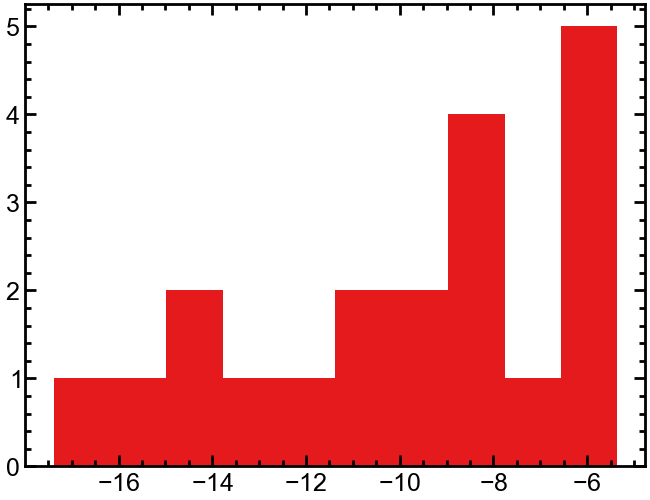

In [26]:
plt.hist(ljpcff.targets)

In [27]:
datacopy = ljpcff.data.copy()
datacopy["fitE"] = a
datacopy["target"] = ljpcff.targets
datacopy

,TOTAL,ELEC,VDW,KEY,M_ENERGY,n_monomers,C_ENERGY,intE,C_ENERGY_kcalmol,DUMMY,fitE,target
100_0_DCM_0_0,10.46182,-2.32637,-38.95443,100_0_DCM_0_0,-19187.350847,20,-19187.382260,-19.712028,-1.204014e+07,0.0,6.626482,-17.385658
100_10_DCM_10_10,9.76092,-2.95220,-24.17201,100_10_DCM_10_10,-19187.352147,20,-19187.366770,-9.175594,-1.204013e+07,0.0,17.823675,-6.223393
100_11_DCM_11_11,11.82532,-2.99249,-27.56097,100_11_DCM_11_11,-19187.336860,20,-19187.360500,-14.834535,-1.204013e+07,0.0,17.005793,-11.842045
100_12_DCM_12_12,8.70544,-3.16304,-33.85436,100_12_DCM_12_12,-19187.330964,20,-19187.345030,-8.826614,-1.204012e+07,0.0,22.368610,-5.663574
100_13_DCM_13_13,11.05635,-2.26642,-22.12830,100_13_DCM_13_13,-19187.342436,20,-19187.354709,-7.701269,-1.204012e+07,0.0,19.513914,-5.434849
100_14_DCM_14_14,9.35699,-3.27240,-23.88499,100_14_DCM_14_14,-19187.348262,20,-19187.367455,-12.043082,-1.204013e+07,0.0,18.394848,-8.770681
100_15_DCM_15_15,10.46829,-0.99411,-29.13696,100_15_DCM_15_15,-19187.359385,20,-19187.370512,-6.982195,-1.204013e+07,0.0,18.896749,-5.988084
100_16_DCM_16_16,8.72384,-2.40845,-28.78625,100_16_DCM_16_16,-19187.367479,20,-19187.385197,-11.118594,-1.204014e+07,0.0,8.932964,-8.710144
100_17_DCM_17_17,10.41901,-4.07463,-28.01418,100_17_DCM_17_17,-19187.347721,20,-19187.367643,-12.501284,-1.204013e+07,0.0,23.073700,-8.426655
100_18_DCM_18_18,9.78891,-1.90086,-33.25026,100_18_DCM_18_18,-19187.358806,20,-19187.373933,-9.492338,-1.204013e+07,0.0,26.341282,-7.591478


In [28]:
datacopy = datacopy.loc[names]
datacopy["EPOL"] = polE
datacopy["CI"] = ciE

In [29]:
datacopy

,TOTAL,ELEC,VDW,KEY,M_ENERGY,n_monomers,C_ENERGY,intE,C_ENERGY_kcalmol,DUMMY,fitE,target,EPOL,CI
100_0_DCM_0_0,10.46182,-2.32637,-38.95443,100_0_DCM_0_0,-19187.350847,20,-19187.382260,-19.712028,-1.204014e+07,0.0,6.626482,-17.385658,-0.930137,-22.408649
100_1_DCM_1_1,9.26687,-2.87067,-33.14880,100_1_DCM_1_1,-19187.348046,20,-19187.365141,-10.727158,-1.204013e+07,0.0,20.297577,-7.856487,-1.315078,-26.437434
100_2_DCM_2_2,9.31088,-1.80053,-31.03154,100_2_DCM_2_2,-19187.340161,20,-19187.367136,-16.926831,-1.204013e+07,0.0,4.149943,-15.126301,-1.456290,-19.178048
100_3_DCM_3_3,9.46549,-3.85909,-32.20855,100_3_DCM_3_3,-19187.331357,20,-19187.352384,-13.194738,-1.204012e+07,0.0,20.896793,-9.335648,-1.673463,-34.728436
100_4_DCM_4_4,9.65906,-3.41737,-28.32044,100_4_DCM_4_4,-19187.350655,20,-19187.379647,-18.192711,-1.204014e+07,0.0,8.306705,-14.775341,-1.421994,-24.458946
100_5_DCM_5_5,10.67199,-3.90189,-34.14801,100_5_DCM_5_5,-19187.358329,20,-19187.379848,-13.503250,-1.204014e+07,0.0,18.864079,-9.601359,-1.151679,-34.006678
100_6_DCM_6_6,8.80933,-3.14770,-29.96899,100_6_DCM_6_6,-19187.349948,20,-19187.372958,-14.439258,-1.204013e+07,0.0,15.333282,-11.291558,-1.359028,-28.240289
100_7_DCM_7_7,8.19969,-2.31133,-27.92680,100_7_DCM_7_7,-19187.360520,20,-19187.372740,-7.667666,-1.204013e+07,0.0,11.163544,-5.356337,-0.859601,-16.600135
100_8_DCM_8_8,9.82647,-1.28969,-38.13678,100_8_DCM_8_8,-19187.354245,20,-19187.376712,-14.098330,-1.204014e+07,0.0,13.704776,-12.808640,-1.849137,-26.417837
100_9_DCM_9_9,8.83827,-2.95552,-28.72102,100_9_DCM_9_9,-19187.351445,20,-19187.373646,-13.931514,-1.204013e+07,0.0,5.724719,-10.975994,-0.856484,-18.116766


In [30]:
np.sqrt(calc_rmse(
    datacopy.intE,
    datacopy.fitE + datacopy.CI + datacopy.EPOL
))

1.5611539003607882

In [31]:
np.std(    
    datacopy.intE -
    (datacopy.fitE + datacopy.CI + datacopy.EPOL)
      )

1.537805993890626

In [65]:
np.sqrt(calc_rmse(
datacopy.intE,
    datacopy.fitE + datacopy.ELEC + datacopy.EPOL
))

2.5498506817236657

In [66]:
np.sqrt(calc_rmse(FFOBJ.data.intE, a_ + FFOBJ.data.ELECp))

2.0935070475286603

Text(0, 0.5, 'FF ENERGY [kcal/mol]')

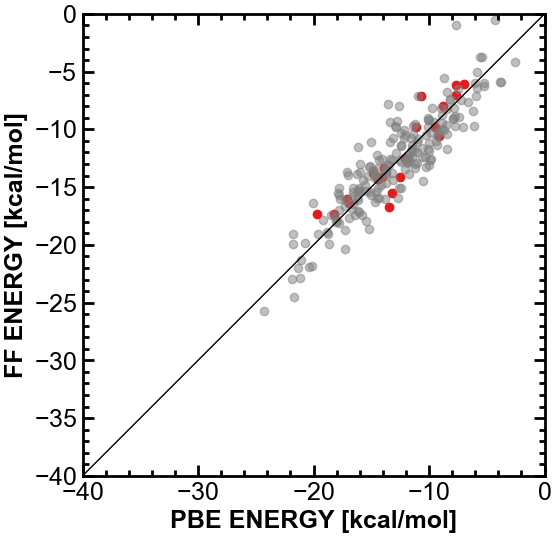

In [34]:
plt.scatter(
            datacopy.intE,
            datacopy.fitE + datacopy.CI, 
           )
plt.scatter(FFOBJ.data.intE, a_ + FFOBJ.data.ELECci,  c="gray", alpha=0.5)

plt.plot([-120, 0], [-120, 0], c="k")

plt.xlim(-40, 0)
plt.ylim(-40, 0)
plt.gca().set_aspect('equal')

plt.xlabel("PBE ENERGY [kcal/mol]")
plt.ylabel("FF ENERGY [kcal/mol]")
# plt.savefig("water_pc_test.png")

In [178]:
datacopy.ELEC + datacopy.EPOL

KEY
test0     -90.185183
test1     -98.831144
test2     -98.630625
test3     -97.445361
test4     -68.935968
test5    -100.369313
test6    -108.324734
test7     -75.931151
test8    -101.815509
test9     -92.246431
test10   -105.932221
test11    -94.888240
test12    -80.167325
test13    -91.430018
test14    -83.876379
test15    -83.656513
test16   -100.168548
test17    -72.367368
test18    -91.562326
test19    -95.744461
dtype: float64

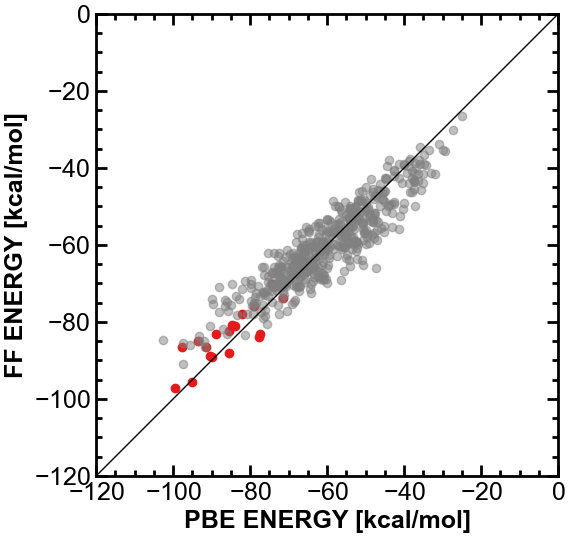

In [197]:
plt.scatter(datacopy.intE,
    datacopy.fitE + datacopy.ELEC + datacopy.EPOL
            )
plt.scatter(FFOBJ.data.intE, a_ + FFOBJ.data.ELEC, c="gray", alpha=0.5)

plt.plot([-120, 0], [-120, 0], c="k")

plt.xlim(-120, 0)
plt.ylim(-120, 0)
plt.gca().set_aspect('equal')

plt.xlabel("PBE ENERGY [kcal/mol]")
plt.ylabel("FF ENERGY [kcal/mol]")
plt.savefig("water_pc_pol_test.png")